In [1]:
!pip install nibabel

In [154]:
!pip install seaborn

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import nibabel as nib
from models import unet
from utils import min_max_normalization

In [3]:
def dice_coef(y_true, y_pred):
    ''' Metric used for CNN training'''
    smooth = 1.0 #CNN dice coefficient smooth
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    ''' Loss function'''
    return -(dice_coef(y_true, y_pred)) # try negative log of the DICE* (-tf.math.log())

In [4]:
def dice_eval(gt, pred):
    dice = 2*(pred*gt).sum()/(pred.sum() + gt.sum())
    return dice
    
def multilabel_dice_eval(gt,pred,labels = [1,2,3]):
    dice_scores = []
    for ii in labels:
        pred_bin = (pred == ii)
        gt_bin = (gt == ii)
        dice_scores.append(dice_eval(gt_bin, pred_bin))
    return dice_scores

In [5]:
def pad_volume(data,multiple):
    _,d2,d3 = data.shape
    rem2 = multiple - d2%multiple 
    rem3 = multiple - d3%multiple
    return np.pad(data,pad_width = ((0,0),(0,rem2),(0,rem3)))

In [6]:
def gen_dice(y_true, y_pred, eps=1e-6):
    """both tensors are [b, h, w, classes] and y_pred is in logit form"""

    # [b, h, w, classes]
    pred_tensor = tf.nn.softmax(y_pred)
    y_true_shape = tf.shape(y_true)

    # [b, h*w, classes]
    y_true = tf.reshape(y_true, [-1, y_true_shape[1]*y_true_shape[2]])
    y_pred = tf.reshape(pred_tensor, [-1, y_true_shape[1]*y_true_shape[2]])

    # [b, classes]
    # count how many of each class are present in 
    # each image, if there are zero, then assign
    # them a fixed weight of eps
    counts = tf.reduce_sum(y_true, axis=1)
    weights = 1. / (counts ** 2)
    weights = tf.where(tf.math.is_finite(weights), weights, eps)

    multed = tf.reduce_sum(y_true * y_pred, axis=1)
    summed = tf.reduce_sum(y_true + y_pred, axis=1)

    # [b]
    numerators = tf.reduce_sum(weights*multed, axis=-1)
    denom = tf.reduce_sum(weights*summed, axis=-1)
    dices = 1. - 2. * numerators / denom
    dices = tf.where(tf.math.is_finite(dices), dices, tf.zeros_like(dices))
    return tf.reduce_mean(dices)

In [7]:
data_path = "C:\\Users\\David Cooksley\\Documents\\School\\ENEL645\\Project\\enel645-final-project\\unet-segmentation\\Data\\Original"
test_files = "C:\\Users\\David Cooksley\\Documents\\School\\ENEL645\\Project\\enel645-final-project\\unet-segmentation\\Data\\test-set.txt"
test_files = np.loadtxt(test_files,dtype = str)
test_files = [os.path.join(data_path, f + ".gz") for f in test_files]

label01_path = "C:\\Users\\David Cooksley\\Documents\\School\\ENEL645\\Project\\enel645-final-project\\unet-segmentation\\Data\\Brain-masks"
label01_files = "C:\\Users\\David Cooksley\\Documents\\School\\ENEL645\\Project\\enel645-final-project\\unet-segmentation\\Data\\test-set.txt"
label01_files = np.loadtxt(label01_files,dtype = str)
label01_files = [os.path.join(label01_path, f.split('.')[0] + "_staple.nii.gz") for f in label01_files]

label02_path = "C:\\Users\\David Cooksley\\Documents\\School\\ENEL645\\Project\\enel645-final-project\\unet-segmentation\\Data\\WM-GM-CSF"
label02_files = "C:\\Users\\David Cooksley\\Documents\\School\\ENEL645\\Project\\enel645-final-project\\unet-segmentation\\Data\\test-set.txt"
label02_files = np.loadtxt(label02_files,dtype = str)
label02_files = [os.path.join(label02_path, f + ".gz") for f in label02_files]

files = zip(test_files, label01_files, label02_files)

multiple = 2**4 # the network has 4 max-pooling layers

In [8]:
model_name = "unet_multitask_halfset.h5"
model = unet(input_shape=(None, None, 1))
model.load_weights(model_name)
model.compile(loss = dice_coef_loss, optimizer=Adam())

In [9]:
data = nib.load(test_files[0]).get_fdata()
label01 = nib.load(label01_files[0]).get_fdata()
label02 = nib.load(label02_files[0]).get_fdata()
data = min_max_normalization(data)
data = data.transpose(2,0,1) # axial slices first
label01 = label01.transpose(2,0,1) # axial slices first
label02 = label02.transpose(2,0,1) # axial slices first

H,W,Z = data.shape
data_padded = pad_volume(data,16)
pred01,pred02 = model.predict(data_padded[:,:,:,np.newaxis])
pred01 = pred01[:,:W,:Z,0] > 0.5
pred01 = pred01.astype(np.double)
pred02 = pred02[:,:W,:Z,:].argmax(axis = -1)*pred01 

In [10]:
staple_score = dice_eval(label01, pred01)
wm_score,gm_score,csf_score = multilabel_dice_eval(label02, pred02)

ERROR! Session/line number was not unique in database. History logging moved to new session 552


In [16]:
import matplotlib.patches as mpatches

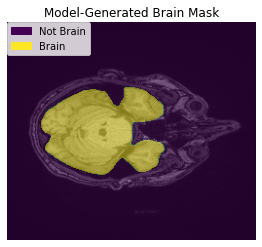

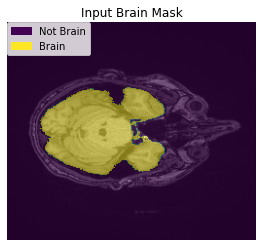

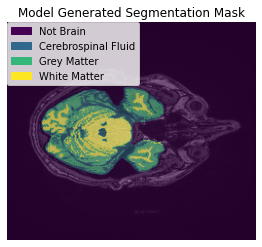

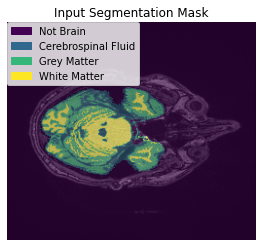

In [54]:
idx = 120
plt.figure()
plt.imshow(data[idx], cmap = "gray")
im1 = plt.imshow(pred01[idx], alpha = 0.5)
values = np.unique(pred01.ravel())
colors = [im1.cmap(im1.norm(value)) for value in values]
labels = ["Not Brain", "Brain"]
patches = [ mpatches.Patch(color = colors[i], label = labels[i]) for i in range(len(values))]
plt.legend(handles=patches, loc=2, borderaxespad=0. )
plt.title("Model-Generated Brain Mask")
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(data[idx], cmap = "gray")
label01_bin = label01 > 0.5
im2 = plt.imshow(label01_bin[idx], alpha = 0.5)
values = np.unique(label01_bin.ravel())
colors = [im2.cmap(im2.norm(value)) for value in values]
labels = ["Not Brain", "Brain"]
patches = [ mpatches.Patch(color = colors[i], label = labels[i]) for i in range(len(values))]
#patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, loc=2, borderaxespad=0.)
plt.title("Input Brain Mask")
plt.axis("off")
plt.show()


plt.figure()
plt.imshow(data[idx], cmap = "gray")
im3 = plt.imshow(pred02[idx], alpha = 0.5)
values = np.unique(pred02.ravel())
colors = [im3.cmap(im3.norm(value)) for value in values]
labels = ["Not Brain", "Cerebrospinal Fluid", "Grey Matter", "White Matter"]
patches = [ mpatches.Patch(color = colors[i], label = labels[i]) for i in range(len(values))]
plt.legend(handles=patches, loc=2, borderaxespad=0. )
plt.title("Model Generated Segmentation Mask")
plt.axis("off")
plt.show()  

plt.figure()
plt.imshow(data[idx], cmap = "gray")
im4 = plt.imshow(label02[idx], alpha = 0.5)
values = np.unique(pred02.ravel())
colors = [im4.cmap(im4.norm(value)) for value in values]
labels = ["Not Brain", "Cerebrospinal Fluid", "Grey Matter", "White Matter"]
patches = [ mpatches.Patch(color = colors[i], label = labels[i]) for i in range(len(values))]
plt.legend(handles=patches, loc=2, borderaxespad=0. )
plt.title("Input Segmentation Mask")
plt.axis("off")
plt.show()  

In [10]:
idx = 120
scores01 = np.zeros(48)
scores02 = np.zeros((48,3))

for i, (ii, jj, kk) in enumerate(zip(test_files, label01_files, label02_files)):
    data = nib.load(ii).get_fdata()
    label01 = nib.load(jj).get_fdata()
    label02 = nib.load(kk).get_fdata()
    
    data = min_max_normalization(data)
    data = data.transpose(2,0,1) # axial slices first
    label01 = label01.transpose(2,0,1) # axial slices first
    label02 = label02.transpose(2,0,1) # axial slices first
    
    
    H,W,Z = data.shape
    data_padded = pad_volume(data,16)
    pred01,pred02 = model.predict(data_padded[:,:,:,np.newaxis])
    pred01 = pred01[:,:W,:Z,0] > 0.5
    pred01 = pred01.astype(np.double)
    pred02 = pred02[:,:W,:Z,:].argmax(axis = -1)*pred01
    
    # print("Finished loop: " + str(i))
    score = dice_eval(label01, pred01)
    a,b,c = multilabel_dice_eval(label02, pred02)
    scores01[i] = score
    scores02[i] = [a, b, c]
    print("Finished loop: " + str(i))
    print("Score 01: " + str(scores01[i]))
    print("Score 02: " + str(scores02[i]))

ERROR! Session/line number was not unique in database. History logging moved to new session 510
Finished loop: 0
Score 01: 0.9843942026020234
Score 02: [0.91172407 0.96436056 0.97831801]
Finished loop: 1
Score 01: 0.9865639822842784
Score 02: [0.920988   0.96417099 0.97779692]
Finished loop: 2
Score 01: 0.9810796700896428
Score 02: [0.89623171 0.95594329 0.97188387]
Finished loop: 3
Score 01: 0.9859654320018142
Score 02: [0.91381845 0.96807014 0.97909505]
Finished loop: 4
Score 01: 0.9843829253522322
Score 02: [0.87983494 0.95434016 0.9755346 ]
Finished loop: 5
Score 01: 0.985568329034684
Score 02: [0.90735496 0.96656666 0.97795203]
Finished loop: 6
Score 01: 0.9848414461309272
Score 02: [0.90924081 0.97191242 0.98245614]
Finished loop: 7
Score 01: 0.9842078664507832
Score 02: [0.89649227 0.96736718 0.97809025]
Finished loop: 8
Score 01: 0.9819363261229447
Score 02: [0.91380396 0.95933777 0.97535896]
Finished loop: 9
Score 01: 0.979426809654594
Score 02: [0.86955874 0.93978245 0.971397

In [11]:
with open('scores01_halfset.npy', 'wb') as f:
    np.save(f, scores01)
with open('scores02_halfset.npy', 'wb') as f:
    np.save(f, scores02)

In [12]:
model_name = "unet_multitask_female.h5"
model = unet(input_shape=(None, None, 1))
model.load_weights(model_name)
model.compile(loss = dice_coef_loss, optimizer=Adam())

In [13]:
image = nib.load(label01_files[0]).get_fdata()
image.shape

(224, 256, 256)

In [14]:
idx = 120
scores01 = np.zeros(48)
scores02 = np.zeros((48,3))

for i, (ii, jj, kk) in enumerate(zip(test_files, label01_files, label02_files)):
    data = nib.load(ii).get_fdata()
    label01 = nib.load(jj).get_fdata()
    label02 = nib.load(kk).get_fdata()
    
    data = min_max_normalization(data)
    data = data.transpose(2,0,1) # axial slices first
    label01 = label01.transpose(2,0,1) # axial slices first
    label02 = label02.transpose(2,0,1) # axial slices first
    
    
    H,W,Z = data.shape
    data_padded = pad_volume(data,16)
    pred01,pred02 = model.predict(data_padded[:,:,:,np.newaxis])
    pred01 = pred01[:,:W,:Z,0] > 0.5
    pred01 = pred01.astype(np.double)
    pred02 = pred02[:,:W,:Z,:].argmax(axis = -1)*pred01
    
    # print("Finished loop: " + str(i))
    score = dice_eval(label01, pred01)
    a,b,c = multilabel_dice_eval(label02, pred02)
    scores01[i] = score
    scores02[i] = [a, b, c]
    print("Finished loop: " + str(i))
    print("Score 01: " + str(scores01[i]))
    print("Score 02: " + str(scores02[i]))

Finished loop: 0
Score 01: 0.9836050117543165
Score 02: [0.90683639 0.95786452 0.97373575]
Finished loop: 1
Score 01: 0.9865523266439608
Score 02: [0.92607883 0.97178801 0.98279964]
Finished loop: 2
Score 01: 0.9805576196302759
Score 02: [0.90324289 0.96703347 0.97858575]
Finished loop: 3
Score 01: 0.9856677628582019
Score 02: [0.91622344 0.97101205 0.98082323]
Finished loop: 4
Score 01: 0.9820875990127166
Score 02: [0.86439501 0.95301692 0.97549432]
Finished loop: 5
Score 01: 0.9865580085524815
Score 02: [0.91747775 0.96754607 0.97685854]
Finished loop: 6
Score 01: 0.98543907802268
Score 02: [0.91176674 0.96934033 0.98084664]
Finished loop: 7
Score 01: 0.9851206838551745
Score 02: [0.90520619 0.97027678 0.9804521 ]
Finished loop: 8
Score 01: 0.9813380304507593
Score 02: [0.91004435 0.95514741 0.9746345 ]
Finished loop: 9
Score 01: 0.9817798342708864
Score 02: [0.89549185 0.95524746 0.97537777]
Finished loop: 10
Score 01: 0.981727004267099
Score 02: [0.89788408 0.97010126 0.98672515]
F

In [15]:
with open('scores01_female.npy', 'wb') as f:
    np.save(f, scores01)
with open('scores02_female.npy', 'wb') as f:
    np.save(f, scores02)

# Results Processing

In [2]:
file_names = np.loadtxt("C:\\Users\\David Cooksley\\Documents\\School\\ENEL645\\Project\\enel645-final-project\\unet-segmentation\\Data\\test-set.txt",dtype = str)
file_names = [f.split(".")[0] for f in file_names]

manufacturer = [f.split("_")[1] for f in file_names]
field_strength = [f.split("_")[2] for f in file_names]
sex = [f.split("_")[4] for f in file_names]

In [3]:
scores01_halfset = np.load("scores01_halfset.npy")
scores02_halfset = np.load("scores02_halfset.npy")
scores01_male = np.load("scores01_M.npy")
scores02_male = np.load("scores02_M.npy")
scores01_female = np.load("scores01_female.npy")
scores02_female = np.load("scores02_female.npy")
scores01_fullset = np.load("scores01_full_set.npy")
scores02_fullset = np.load("scores02_full_set.npy")

In [4]:
d_halfset = {'manufacturer':manufacturer, 'field_strength':field_strength, 'sex':sex,
     'staple_score':scores01_halfset, 'white_matter_score':scores02_halfset[:,2], 'grey_matter_score':scores02_halfset[:,1], 'csf_score':scores02_halfset[:,0]}
d_female = {'manufacturer':manufacturer, 'field_strength':field_strength, 'sex':sex,
    'staple_score':scores01_female, 'white_matter_score':scores02_female[:,2], 'grey_matter_score':scores02_female[:,1], 'csf_score':scores02_female[:,0]}
d_fullset = {'manufacturer':manufacturer, 'field_strength':field_strength, 'sex':sex,
    'staple_score':scores01_fullset, 'white_matter_score':scores02_fullset[:,2], 'grey_matter_score':scores02_fullset[:,1], 'csf_score':scores02_fullset[:,0]}
d_male = {'manufacturer':manufacturer, 'field_strength':field_strength, 'sex':sex,
    'staple_score':scores01_male, 'white_matter_score':scores02_male[:,2], 'grey_matter_score':scores02_male[:,1], 'csf_score':scores02_male[:,0]}

In [5]:
score_frame_halfset = pd.DataFrame(data=d_halfset)
score_frame_female = pd.DataFrame(data=d_female)
score_frame_fullset = pd.DataFrame(data=d_fullset)
score_frame_male = pd.DataFrame(data=d_male)

In [27]:
score_frame_halfset.groupby('sex').mean()

,staple_score,white_matter_score,grey_matter_score,csf_score
sex,,,,
F,0.986584,0.975157,0.956715,0.891703
M,0.984956,0.976502,0.955062,0.890179


In [28]:
score_frame_female.groupby('sex').mean()

,staple_score,white_matter_score,grey_matter_score,csf_score
sex,,,,
F,0.986621,0.977917,0.961106,0.896083
M,0.984969,0.976800,0.956746,0.892150


In [29]:
score_frame_fullset.groupby('sex').mean()

,staple_score,white_matter_score,grey_matter_score,csf_score
sex,,,,
F,0.987404,0.980540,0.965081,0.904131
M,0.986061,0.980199,0.962455,0.902991


In [30]:
score_frame_male.groupby('sex').mean()

,staple_score,white_matter_score,grey_matter_score,csf_score
sex,,,,
F,0.986028,0.974162,0.954877,0.890276
M,0.985260,0.976676,0.956246,0.895317


In [6]:
score_frame_halfset.describe()

,staple_score,white_matter_score,grey_matter_score,csf_score
count,48.000000,48.000000,48.000000,48.000000
mean,0.985770,0.975829,0.955889,0.890941
std,0.003320,0.005385,0.012270,0.022428
min,0.969301,0.965133,0.924481,0.840589
25%,0.985052,0.971869,0.948743,0.876407
50%,0.986493,0.976064,0.957920,0.895294
75%,0.987653,0.979170,0.965131,0.907603
max,0.989462,0.988508,0.975130,0.923453


In [32]:
fem_plot_data = pd.DataFrame(columns=['sex','score_type','score'])
for idx, row in score_frame_female.iterrows():
    i = idx*4
    fem_plot_data.loc[i] = [row['sex'],'whole_brain',row['staple_score']]
    fem_plot_data.loc[i+1] = [row['sex'],'white_matter',row['white_matter_score']]
    fem_plot_data.loc[i+2] = [row['sex'],'grey_matter',row['grey_matter_score']]
    fem_plot_data.loc[i+3] = [row['sex'],'csf',row['csf_score']]

In [68]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.3f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

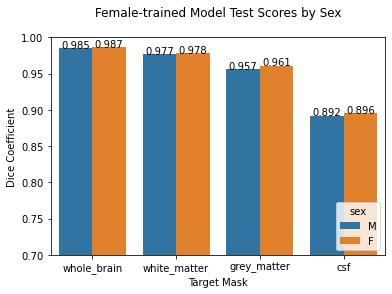

In [69]:
ax1 = sns.barplot(data=fem_plot_data, x="score_type", y="score", hue="sex", ci=None)
ax1.set(ylim=(0.7, 1), title="Female-trained Model Test Scores by Sex\n",xlabel="Target Mask",ylabel="Dice Coefficient")
plt.legend(loc="lower right", title="sex")
show_values_on_bars(ax1)

In [34]:
male_plot_data = pd.DataFrame(columns=['sex','score_type','score'])
for idx, row in score_frame_male.iterrows():
    i = idx*4
    male_plot_data.loc[i] = [row['sex'],'whole_brain',row['staple_score']]
    male_plot_data.loc[i+1] = [row['sex'],'white_matter',row['white_matter_score']]
    male_plot_data.loc[i+2] = [row['sex'],'grey_matter',row['grey_matter_score']]
    male_plot_data.loc[i+3] = [row['sex'],'csf',row['csf_score']]

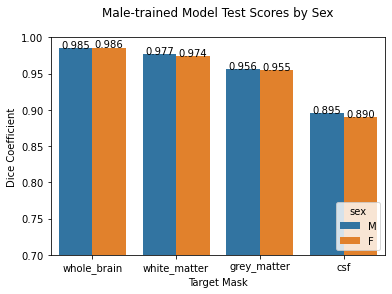

In [70]:
ax2 = sns.barplot(data=male_plot_data, x="score_type", y="score", hue="sex", ci=None)
ax2.set(ylim=(0.7, 1), title="Male-trained Model Test Scores by Sex\n",xlabel="Target Mask",ylabel="Dice Coefficient")
plt.legend(loc="lower right", title="sex")
show_values_on_bars(ax2)

In [36]:
half_plot_data = pd.DataFrame(columns=['sex','score_type','score'])
for idx, row in score_frame_halfset.iterrows():
    i = idx*4
    half_plot_data.loc[i] = [row['sex'],'whole_brain',row['staple_score']]
    half_plot_data.loc[i+1] = [row['sex'],'white_matter',row['white_matter_score']]
    half_plot_data.loc[i+2] = [row['sex'],'grey_matter',row['grey_matter_score']]
    half_plot_data.loc[i+3] = [row['sex'],'csf',row['csf_score']]

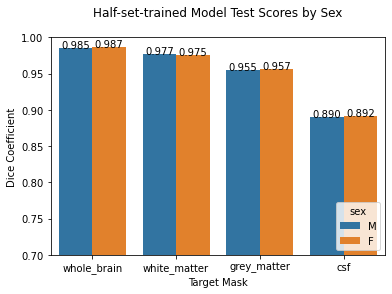

In [71]:
ax3 = sns.barplot(data=half_plot_data, x="score_type", y="score", hue="sex", ci=None)
ax3.set(ylim=(0.7, 1), title="Half-set-trained Model Test Scores by Sex\n",xlabel="Target Mask",ylabel="Dice Coefficient")
plt.legend(loc="lower right", title="sex")
show_values_on_bars(ax3)

In [38]:
full_plot_data = pd.DataFrame(columns=['sex','score_type','score'])
for idx, row in score_frame_fullset.iterrows():
    i = idx*4
    full_plot_data.loc[i] = [row['sex'],'whole_brain',row['staple_score']]
    full_plot_data.loc[i+1] = [row['sex'],'white_matter',row['white_matter_score']]
    full_plot_data.loc[i+2] = [row['sex'],'grey_matter',row['grey_matter_score']]
    full_plot_data.loc[i+3] = [row['sex'],'csf',row['csf_score']]

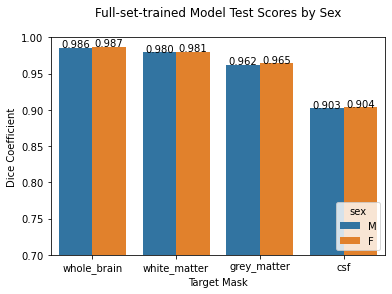

In [72]:
ax4 = sns.barplot(data=full_plot_data, x="score_type", y="score", hue="sex", ci=None)
ax4.set(ylim=(0.7, 1), title="Full-set-trained Model Test Scores by Sex\n",xlabel="Target Mask",ylabel="Dice Coefficient")
plt.legend(loc="lower right", title="sex")
show_values_on_bars(ax4)

In [40]:
fem_plot_data["model"] = "female"
male_plot_data["model"] = "male"
half_plot_data["model"] = "half-set"
full_plot_data["model"] = "full-set"

In [41]:
all_models_data = fem_plot_data.append(male_plot_data).append(half_plot_data).append(full_plot_data)

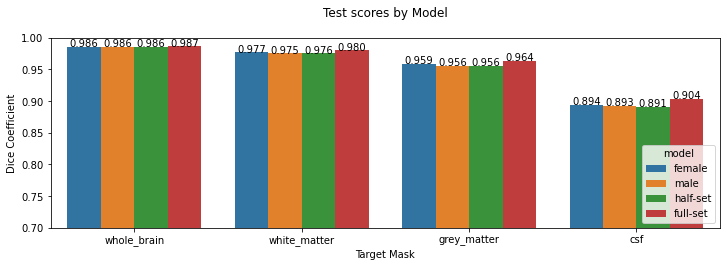

In [94]:
ax = sns.barplot(data=all_models_data, x="score_type", y="score", hue="model", ci=None)
ax.set(ylim=(0.7,1), title="Test scores by Model\n",xlabel="Target Mask",ylabel="Dice Coefficient")
plt.legend(loc="lower right", title="model")
plt.rcParams["figure.figsize"] = 12,3.5
show_values_on_bars(ax)